1. The data is processed to obtain the quadrangular coordinates of each gird $g_{i,1}$, $g_{i,2}$, $g_{i,3}$, $g_{i,4}$
2. get the center point of gird $g_i=\frac{1}{4}\sum\limits _{j=1}^{4}g_{i,j}$


In [124]:
import numpy as np
import pandas as pd
import copy
from geopy.distance import geodesic
filePath_01='D:/Study/MMCS/project/orig_data/Demand_data.xlsx'
filePath_02='D:/Study/MMCS/project/orig_data/Potential_charging_points.xlsx'
filePath_03='D:/Study/MMCS/project/orig_data/Charging_points.xlsx'
dem=pd.read_excel(filePath_01,sheet_name='Sheet1') # grid num_of_stations dis_center demand1,2,3
pot=pd.read_excel(filePath_02,sheet_name='Sheet1') # potential_points
cha=pd.read_excel(filePath_03,sheet_name='Sheet1') # existing_charging_stations

# The data is processed to obtain the quadrangular coordinates of each gird
# turn (lng,lat) to (lat,lng)
geometry=copy.deepcopy(dem['geometry'])
for i in range(len(geometry)):
    geometry[i]=geometry[i][10:-2]
    geometry[i]=[tuple(float(j) for j in i.split()[::-1]) for i in geometry[i].split(',')]
    geometry[i]=geometry[i]

# get the center point of gird
loca=[[0,0] for i in range(len(geometry))]
for i in range(len(geometry)):
    for j in range(len(geometry[i])-1):
        for k in range(len(geometry[i][j])):
            loca[i][k]+=geometry[i][j][k]
    loca[i][0]=loca[i][0]/4
    loca[i][1]=loca[i][1]/4
    loca[i]=tuple(loca[i])

# get locations of existing stations
# get locations of potential points
eloca=[tuple(float(i) for i in r[7:-1].split()[::-1]) for r in cha['geometry']]
ploca=[tuple(float(i) for i in r[7:-1].split()[::-1]) for r in pot['geometry']]

3. calculate the distance between girds and potential points with function geodesic in a package called geopy
4. the unit is meters


In [125]:
# calculate the distance, the unit is meters(lat,lng)
# distance matrix girds--potential points
A=tuple(tuple(round(geodesic(loca[i],ploca[j]).m,1) for j in range(len(ploca))) for i in range(len(loca)))
# row i :grid i corresponding to every potential
# row: grid center
# col: potential points

In [126]:
# index of potential points
indexp=tuple(f"p{i+1}" for i in range(len(ploca)))
# creat table
table1=pd.DataFrame(A,columns=indexp)
# add Distance from Centre
table1.insert(loc=0,column='Distance from Centre',value=tuple(dem['Distance from Centre']))

# get all demand
for i in range(4):
    table1.insert(loc=0,column=f'Demand_{3-i}', value=tuple(dem[f'Demand_{3-i}']))

# gird id
table1.insert(loc=0, column='Grid_id', value=range(1,len(A)+1))


1. tidy data remove all the girds which have no demand, to make computers do calculations faster
2. There are some grids with too much grid and it's improper to make one point to supply such a grid. 
3. here we use 5000 as the uppper demand
4. we decide to divide these girds into smaller grids with lower demand. 
5. a gird will be divided into $n=\lfloor dem/(upper+1)\rfloor$ smaller girds and their demand will be $dem_{new}=\dfrac{dem}{n}$

In [127]:
# remove all girds without demand
nodemList=[]
for i in range(len(table1)-1,-1,-1):
    #if all(table1.loc[i][['Demand_0','Demand_1','Demand_2','Demand_3']]==0):
    if max(table1.loc[i][['Demand_0','Demand_1','Demand_2','Demand_3']])<=500:
        nodemList.append(i)

table1 = table1.drop(labels=nodemList)
table1=table1.reset_index(drop=True)
    
# demand of some girds are too large, they need be divided
needupper=10000
ntable1=len(table1)
for i in range(ntable1):
    need=max(table1.loc[i,['Demand_0','Demand_1','Demand_2','Demand_3']])
    if need>needupper:
        div=int(need//needupper+1)
        table1.loc[i,'Demand_0']=copy.copy(table1.loc[i,'Demand_0']/div)
        table1.loc[i,'Demand_1']=copy.copy(table1.loc[i,'Demand_1']/div)
        table1.loc[i,'Demand_2']=copy.copy(table1.loc[i,'Demand_2']/div)
        table1.loc[i,'Demand_3']=copy.copy(table1.loc[i,'Demand_3']/div)
        for j in range(div):
            table1.loc[len(table1)]=copy.copy(table1.loc[i])
table1=table1.sort_values(by='Grid_id')
table1=table1.reset_index(drop=True)
table1['Grid_id'] = table1['Grid_id'].astype(np.int64)


In [128]:
# save in csv
# coding:utf-8
table1.to_csv('allinone.csv')

In [129]:
xprDist=[]
for i in range(len(table1)):
    for j in range(len(ploca)):
        xprDist.append((j+1,i+1,table1.iloc[i,j+6]))
xprDist=pd.DataFrame(xprDist)
xprDist.to_csv('xpressDist.csv')

In [130]:
xprDem=[]
for i in range(len(table1)):
    for j in range(4):
        xprDem.append((i+1,j+1,table1.iloc[i,j+1]))
xprDem=pd.DataFrame(xprDem)
xprDem.to_csv('xpressDemand.csv')

## existing stations information

existing point

In [131]:
infore=list(range(len(cha['Type'])))
P=[]
while infore!=[]:
    seta=set()
    a=infore.pop()
    seta.add(a)
    for i in infore:
        if geodesic(eloca[a],eloca[i]).m<=50:
            seta.add(infore.pop())
    p=[0,0,0,eloca[a]]
    for i in seta:
        if cha['Type'][i]=='Slow':
            p[0]+=1
        elif cha['Type'][i]=='Fast':
            p[1]+=1
        else:
            p[2]+=1
    P.append(p[:])
    

In [132]:
Xpress_ex_type_num=[]
for i in range(len(P)):
    for j in range(3):
        Xpress_ex_type_num.append((j+1,i+1,P[i][j]))
Xpress_ex_type_num=pd.DataFrame(Xpress_ex_type_num)
Xpress_ex_type_num.to_csv('XpressExNum.csv.csv')

calculate the distance between girds(divided) and existing stations

In [133]:
Ae=tuple(tuple(round(geodesic(loca[j-1],P[i][3]).m,1) for j in table1['Grid_id']) for i in range(len(P)))

In [134]:
# table1['Grid_id']contains the id that needs to be calculated，
# index of loca begin from 0，need -1
# each column is a 'customer', e.i. divided grids
#Ae=tuple(tuple(round(geodesic(loca[j-1],eloca[i]).m,1) for j in table1['Grid_id']) for i in range(len(eloca)))

In [135]:
Aeline=[]
for i in range(len(table1['Grid_id'])):
    for j in range(len(P)):
        Aeline.append((j+1,i+1,Ae[j][i]))
Aeline=pd.DataFrame(Aeline)
Aeline.to_csv('xpressExistdist.csv')

In [136]:
# existing stations information
# index of existing points
#indexe=tuple(i+1 for i in table1['Grid_id'])
# creat table
#table2=pd.DataFrame(Ae,columns=indexe)
# location
#table2.insert(loc=0, column='Location', value=eloca)
# type
#table2.insert(loc=0, column='Type', value=cha['Type'])
# gird id
#table2.insert(loc=0, column='Gird_id', value=cha['grid number'])

In [137]:
# save in csv
# coding:utf-8
#table2.to_csv('existing.csv')

In [144]:
pgrid=pot['grid number']
egrid=cha['grid number']
matrpg=[[0]*len(pgrid) for i in range(len(dem))]
matreg=[[0]*len(egrid) for i in range(len(dem))]
pgline=[]
egline=[]
for i in range(len(pgrid)):
    matrpg[pgrid[i]][i]=1
for i in range(len(dem)):
    for j in range(len(pgrid)):
        pgline.append((j+1,i+1,matrpg[i][j]))
        
for i in range(len(egrid)):
    matreg[egrid[i]][i]=1
for i in range(len(dem)):
    for j in range(len(egrid)):
        egline.append((j+1,i+1,matreg[i][j]))
pgline=pd.DataFrame(pgline)
egline=pd.DataFrame(egline)
pgline.to_csv('pgline.csv')
egline.to_csv('egline.csv')

if gird is in the cneter (i.e. $disc\leq 2000$) then $DC_i=1$

In [139]:
# if gird is in the cneter (i.e. disc<=2000) then DCi=1
disc=[(i+1,1) if dem['Distance from Centre'][i]<=2000 else (i+1,0) for i in range(len(dem))]
disc=pd.DataFrame(disc)
disc.to_csv('dist_center.csv')

Here we plot a map to visualize the distribution of potential points and existing stations

In [180]:
stainpoin=pd.read_csv('gird_point.csv') # grid num_of_stations dis_center demand1,2,3
stainpoin=np.array(stainpoin)
DemSup=np.zeros([325,200,4])
for p in range(len(stainpoin)):
    DemSup[stainpoin[p][0]-1][stainpoin[p][1]-1][stainpoin[p][2]-1]=stainpoin[p][3]

In [181]:
# map
import folium
import webbrowser as wb
latitude=56.480849246733456
longitude=-2.9696938298929183
# Dundee Map
m=folium.Map(location=[latitude,longitude],
             width='100',height='100',
             zoom_start=12,min_zoom=0,max_zoom=18,
             titles='OpenStreetMap')

# point
def pointmap(m,pointlist,col,r=1):
    point=folium.map.FeatureGroup()
    for p in pointlist:
        point.add_child(
            folium.CircleMarker(p,radius=r,color=col,fill=True)
        )
    m.add_child(point)
    
pointmap(m,eloca,col='#0066FF')
pointmap(m,ploca,col='#FF7744')

# grid
for i in range(len(geometry)):
    folium.Polygon(geometry[i],
                   color='gray',weight=0.5,fill=True,fill_opacity=0.2
                   ).add_to(m) 

m.add_child(folium.LatLngPopup()) 
for i in range(325):
    for j in range(200):
        if DemSup[i,j,3]>=1 and table1['Demand_3'][j]!=0:
            folium.PolyLine(
            locations=[       
                ploca[i] ,
                loca[table1['Grid_id'][j]-1],
            ],
            popup=folium.Popup('demand-supply', max_width=10),
            color='red',
            weight=2
            ).add_to(m)

    
m.save('map.html')
wb.open('map.html')

True

### find potential points of which infrastructure has been established

After observing the distribution of points and stations, we assume that if there's a station within $40$ meters of point $i$, we can say that point $i$ has infrastructure.

In [142]:
# find potential points of which infrastructure has been established
pi={}                 # potential points with infrastructure
for i in range(len(eloca)):
    for j in range(len(ploca)):
        d=geodesic(eloca[i],ploca[j]).m
        if d<40:        # 40m seems reasonable
            if j+1 in pi:
                pi[j+1]=pi[j+1]+[(i+1,round(d,1))]
            else:
                pi[j+1]=[(i+1,round(d,1))]
print(", ".join(str(i) for i in pi))

31, 69, 300, 30, 82, 26, 175, 142, 67, 18, 15, 106


### observing the histograms and choose the upper of demand

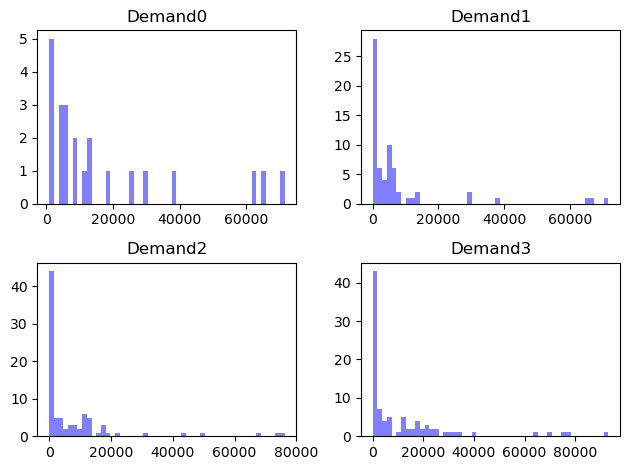

In [143]:
# Histogram of demand in different period
import matplotlib.pyplot as plt
demlist=[]
top,bottom=1000000,10
demlist.append(tuple(i for i in dem['Demand_0'] if top>i>bottom))
demlist.append(tuple(i for i in dem['Demand_1'] if top>i>bottom))
demlist.append(tuple(i for i in dem['Demand_2'] if top>i>bottom))
demlist.append(tuple(i for i in dem['Demand_3'] if top>i>bottom))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(demlist[i], 50, facecolor='blue', alpha=0.5)
    plt.title(f"Demand{i}")
# add a 'best fit' line
plt.tight_layout()
plt.show()
#print(demlist)


In [173]:
stainpoin=pd.read_csv('StationInPoint.csv') # grid num_of_stations dis_center demand1,2,3
stainpoin=np.array(stainpoin)
P=np.zeros([325,4,3]) # points periods types
for p in range(len(stainpoin)):
    P[stainpoin[p][1]-1,stainpoin[p][2]-1,stainpoin[p][0]-1]+=stainpoin[p][3]
for i in range(325):
    if (P[i,:,:]!=0).any():
        print(i+1,P[i,3,:])
    

5 [0. 0. 3.]
6 [0. 0. 1.]
9 [3. 0. 0.]
10 [3. 0. 0.]
12 [1. 0. 0.]
20 [1. 0. 0.]
31 [0. 0. 1.]
38 [2. 0. 0.]
39 [1. 0. 0.]
46 [0. 0. 1.]
52 [3. 0. 0.]
59 [5. 3. 0.]
61 [5. 0. 0.]
70 [2. 6. 0.]
80 [0. 0. 2.]
83 [0. 0. 2.]
87 [1. 0. 0.]
98 [0. 0. 1.]
100 [0. 0. 1.]
112 [1. 0. 0.]
117 [1. 0. 0.]
124 [0. 0. 3.]
133 [1. 0. 0.]
135 [6. 2. 0.]
136 [2. 0. 0.]
137 [1. 7. 0.]
148 [2. 6. 0.]
152 [7. 0. 1.]
155 [0. 0. 3.]
157 [1. 0. 0.]
162 [0. 7. 1.]
167 [0. 0. 1.]
169 [0. 0. 2.]
170 [3. 0. 0.]
174 [0. 0. 1.]
175 [1. 0. 0.]
181 [2. 6. 0.]
182 [6. 2. 0.]
187 [1. 7. 0.]
192 [8. 0. 0.]
201 [1. 0. 0.]
214 [0. 0. 2.]
220 [0. 0. 1.]
234 [0. 0. 1.]
236 [1. 7. 0.]
238 [2. 0. 0.]
240 [1. 0. 0.]
242 [3. 5. 0.]
244 [5. 0. 0.]
245 [3. 5. 0.]
246 [5. 0. 0.]
253 [3. 0. 0.]
254 [1. 0. 0.]
255 [1. 0. 0.]
256 [3. 0. 0.]
257 [0. 0. 1.]
258 [0. 0. 1.]
260 [0. 6. 2.]
262 [1. 0. 0.]
270 [1. 0. 0.]
272 [2. 0. 0.]
277 [1. 0. 0.]
279 [2. 0. 0.]
281 [1. 0. 0.]
284 [2. 0. 0.]
286 [3. 5. 0.]
292 [1. 0. 0.]
317 [1. 0. 0.]


In [170]:
(P[i,:,:]!=0).any()

False